In [2]:
import pandas as pd
import numpy as np
import verispy, os
from verispy import VERIS

[Source for VERISPY + Useful README](https://github.com/RiskLens/verispy)

In [3]:


DATA_DIR ="./data/validated/"
PKL_PATH = "./data/vdf.pkl"

v = VERIS(json_dir=DATA_DIR, verbose=True)

# json_to_df is an expensive function, so we save the converted dataframe for use between sessions. 
if not os.path.exists(PKL_PATH):
    print("we're making pickles")
    vdf = v.json_to_df()
    vdf.to_pickle(PKL_PATH)
vdf = pd.read_pickle(PKL_PATH)
# v.raw_df=vdf
print(vdf.shape)

v.enum_summary(vdf, "action")


Found 8323 json files.
(8323, 2347)


,enum,x,n,freq
0,Error,2418,8105.0,0.29833
1,Hacking,2213,8105.0,0.27304
2,Misuse,1697,8105.0,0.20938
3,Physical,1576,8105.0,0.19445
4,Malware,697,8105.0,0.08600
5,Social,568,8105.0,0.07008
6,Environmental,8,8105.0,0.00099
7,Unknown,218,NaN,NaN


##### v is a VERIS object. vdf contains the actual data. 

[Good StackOverflow Answer on working with Dataframes vvv](https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values)

In [4]:
df_impact = vdf.loc[:, vdf.columns.str.contains('rating')]
print(v.enum_summary(vdf, 'impact.overall_rating'))
print(v.enum_summary(vdf, "impact.loss.rating"))


# v.enum_summary(vdf, "impact.rating"

            enum     x      n     freq
0  Insignificant    52  116.0  0.44828
1    Distracting    25  116.0  0.21552
2       Damaging    20  116.0  0.17241
3        Painful    18  116.0  0.15517
4   Catastrophic     1  116.0  0.00862
5        Unknown  5767    NaN      NaN
       enum  x    n  freq
0     Major  0  0.0   NaN
1     Minor  0  0.0   NaN
2  Moderate  0  0.0   NaN
3      None  0  0.0   NaN
4   Unknown  0  NaN   NaN


In [5]:
df_action = vdf.loc[:, vdf.columns.str.startswith('action')]


In [6]:
df_final = df_action.iloc[:, :7]

In [7]:
df_bugs = vdf[vdf['action.Hacking'] | vdf['action.Malware']]
# print(df_bugs.shape)



In [8]:
indices = list(df_bugs.index)
bugs = [False] * df_final.shape[0]
for i in indices:
    bugs[i] = True

In [9]:
df_final['action.Bugs'] = bugs
df_final

,action.Environmental,action.Error,action.Hacking,action.Malware,action.Misuse,action.Physical,action.Social,action.Bugs
0,False,False,False,False,True,False,False,False
1,False,False,False,False,False,True,False,False
2,False,True,False,False,False,False,False,False
3,False,False,True,False,False,False,False,True
4,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
8318,False,True,False,False,False,False,False,False
8319,False,False,False,False,True,False,False,False
8320,False,False,False,False,True,False,False,False
8321,False,False,False,False,False,True,False,False


In [10]:
#Creates a smaller table for ease of running
N = 1000
sample = np.random.choice(8323, N)
df_short = df_final.iloc[sample,:].reset_index().iloc[:,1:]


# Maybe we should id the column here in the future so we can refer to the original table values

In [11]:
impactful_df = vdf[vdf['impact.overall_rating.Insignificant'] | vdf['impact.overall_rating.Distracting'] | vdf['impact.overall_rating.Painful'] | vdf['impact.overall_rating.Catastrophic'] | vdf['impact.overall_rating.Damaging']].reindex()
reset_impactful_df = impactful_df.reset_index(drop=True) #Resets the indicies
impactful_df_bugs = reset_impactful_df[reset_impactful_df['action.Hacking'] | reset_impactful_df['action.Malware']]
impactful_df_bugs


,action.Environmental,action.Error,action.Hacking,action.Malware,action.Misuse,action.Physical,action.Social,action.Unknown,action.environmental.notes,action.environmental.variety.Deterioration,...,victim.revenue.iso_currency_code.XPF,victim.revenue.iso_currency_code.YER,victim.revenue.iso_currency_code.ZAR,victim.revenue.iso_currency_code.ZMK,victim.revenue.iso_currency_code.ZWD,victim.secondary.amount,victim.secondary.notes,victim.secondary.victim_id,victim.state,victim.victim_id
1,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,CA,Uber
5,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,US-MI,Adrian College
6,False,False,True,False,False,False,True,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,US-IA,Virginia Gay Hospital
7,False,False,False,True,False,False,False,False,NaN,False,...,False,False,False,False,False,1.0,The dentist offices who were compromised could...,[Digital Dental Record],US-WI,PerCSoft
13,False,False,True,True,False,False,True,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,CA-ON,Michael Garron Hospital
14,False,False,True,False,True,True,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,WI,Brinks Security
17,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,Society of Information Risk Analysts
18,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,VA,"Albemarle County, VA"
20,False,False,False,True,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,US-CT,Wolcott school district
23,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,US-KY,Elmcroft Senior Living


In [12]:
indices = list(impactful_df_bugs.index)
bugs = [False] * impactful_df.shape[0]
for i in indices:
    bugs[i] = True
overall_rating = reset_impactful_df.loc[:, reset_impactful_df.columns.str.startswith('impact.overall_rating')]
df_final = reset_impactful_df.iloc[:, :7]
df_final['action.Bugs'] = bugs
result = pd.concat([df_final,overall_rating], axis=1, sort=False)
result = result.iloc[:,:13]
result 

,action.Environmental,action.Error,action.Hacking,action.Malware,action.Misuse,action.Physical,action.Social,action.Bugs,impact.overall_rating.Catastrophic,impact.overall_rating.Damaging,impact.overall_rating.Distracting,impact.overall_rating.Insignificant,impact.overall_rating.Painful
0,False,True,False,False,False,False,False,False,False,True,False,False,False
1,False,False,True,False,False,False,False,True,False,False,False,True,False
2,False,True,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,True,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,False,False,True,False,False,False,True,True,False,False,False,False,True
112,False,False,True,False,False,False,False,True,False,False,True,False,False
113,False,False,False,False,False,False,True,False,False,False,True,False,False
114,False,False,False,True,False,False,False,True,False,False,False,False,True


In [13]:
result
v.enum_summary(result, 'action')
v.enum_summary(result, 'impact.overall_rating')
# result.join('impact.damage')
ranking = {"impact.overall_rating.Catastrophic": 5, 
            "impact.overall_rating.Damaging": 4, 
            "impact.overall_rating.Painful": 3, 
            "impact.overall_rating.Distracting": 2, 
            "impact.overall_rating.Insignificant": 1, 
            }

for row in result.iterrows():
    for rank in ranking:
        print(rank)
        print(row)
#             print('hi')
# result['outcome'] = result.apply(lambda row: for 
# result
# v.enumerations

impact.overall_rating.Catastrophic
(0, action.Environmental                   False
action.Error                            True
action.Hacking                         False
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social                          False
action.Bugs                            False
impact.overall_rating.Catastrophic     False
impact.overall_rating.Damaging          True
impact.overall_rating.Distracting      False
impact.overall_rating.Insignificant    False
impact.overall_rating.Painful          False
Name: 0, dtype: bool)
impact.overall_rating.Damaging
(0, action.Environmental                   False
action.Error                            True
action.Hacking                         False
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social                          False
acti

impact.overall_rating.Painful
(8, action.Environmental                   False
action.Error                           False
action.Hacking                         False
action.Malware                         False
action.Misuse                           True
action.Physical                        False
action.Social                          False
action.Bugs                            False
impact.overall_rating.Catastrophic     False
impact.overall_rating.Damaging         False
impact.overall_rating.Distracting      False
impact.overall_rating.Insignificant     True
impact.overall_rating.Painful          False
Name: 8, dtype: bool)
impact.overall_rating.Distracting
(8, action.Environmental                   False
action.Error                           False
action.Hacking                         False
action.Malware                         False
action.Misuse                           True
action.Physical                        False
action.Social                          False
action

Name: 19, dtype: bool)
impact.overall_rating.Damaging
(19, action.Environmental                   False
action.Error                           False
action.Hacking                         False
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social                           True
action.Bugs                            False
impact.overall_rating.Catastrophic     False
impact.overall_rating.Damaging         False
impact.overall_rating.Distracting      False
impact.overall_rating.Insignificant    False
impact.overall_rating.Painful           True
Name: 19, dtype: bool)
impact.overall_rating.Painful
(19, action.Environmental                   False
action.Error                           False
action.Hacking                         False
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social               

Name: 26, dtype: bool)
impact.overall_rating.Catastrophic
(27, action.Environmental                   False
action.Error                           False
action.Hacking                          True
action.Malware                         False
action.Misuse                          False
action.Physical                         True
action.Social                           True
action.Bugs                             True
impact.overall_rating.Catastrophic     False
impact.overall_rating.Damaging         False
impact.overall_rating.Distracting      False
impact.overall_rating.Insignificant     True
impact.overall_rating.Painful          False
Name: 27, dtype: bool)
impact.overall_rating.Damaging
(27, action.Environmental                   False
action.Error                           False
action.Hacking                          True
action.Malware                         False
action.Misuse                          False
action.Physical                         True
action.Social          

Name: 44, dtype: bool)
impact.overall_rating.Distracting
(44, action.Environmental                   False
action.Error                           False
action.Hacking                         False
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social                          False
action.Bugs                            False
impact.overall_rating.Catastrophic     False
impact.overall_rating.Damaging         False
impact.overall_rating.Distracting      False
impact.overall_rating.Insignificant    False
impact.overall_rating.Painful           True
Name: 44, dtype: bool)
impact.overall_rating.Insignificant
(44, action.Environmental                   False
action.Error                           False
action.Hacking                         False
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social      

(56, action.Environmental                   False
action.Error                           False
action.Hacking                         False
action.Malware                         False
action.Misuse                           True
action.Physical                        False
action.Social                          False
action.Bugs                            False
impact.overall_rating.Catastrophic     False
impact.overall_rating.Damaging          True
impact.overall_rating.Distracting      False
impact.overall_rating.Insignificant    False
impact.overall_rating.Painful          False
Name: 56, dtype: bool)
impact.overall_rating.Catastrophic
(57, action.Environmental                   False
action.Error                            True
action.Hacking                         False
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social                          False
action.Bugs                     

Name: 69, dtype: bool)
impact.overall_rating.Distracting
(69, action.Environmental                   False
action.Error                            True
action.Hacking                         False
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social                          False
action.Bugs                            False
impact.overall_rating.Catastrophic     False
impact.overall_rating.Damaging         False
impact.overall_rating.Distracting      False
impact.overall_rating.Insignificant     True
impact.overall_rating.Painful          False
Name: 69, dtype: bool)
impact.overall_rating.Insignificant
(69, action.Environmental                   False
action.Error                            True
action.Hacking                         False
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social      

impact.overall_rating.Painful
(83, action.Environmental                   False
action.Error                           False
action.Hacking                          True
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social                          False
action.Bugs                             True
impact.overall_rating.Catastrophic     False
impact.overall_rating.Damaging          True
impact.overall_rating.Distracting      False
impact.overall_rating.Insignificant    False
impact.overall_rating.Painful          False
Name: 83, dtype: bool)
impact.overall_rating.Distracting
(83, action.Environmental                   False
action.Error                           False
action.Hacking                          True
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social                          False
act

impact.overall_rating.Distracting
(102, action.Environmental                   False
action.Error                            True
action.Hacking                         False
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social                          False
action.Bugs                            False
impact.overall_rating.Catastrophic     False
impact.overall_rating.Damaging         False
impact.overall_rating.Distracting      False
impact.overall_rating.Insignificant     True
impact.overall_rating.Painful          False
Name: 102, dtype: bool)
impact.overall_rating.Insignificant
(102, action.Environmental                   False
action.Error                            True
action.Hacking                         False
action.Malware                         False
action.Misuse                          False
action.Physical                        False
action.Social                          

In [14]:
result['outcome'] 

imp_name = "impact.overall_rating"
result.apply(outcome: lambda outcome + 1, axis = 1)
idxs = range(len(result))
for i in idxs:
    for rank in ranking.keys():
        if result.[i][rank]:
            print(rank) = 
#     for 
#             print result[rank]
# ranking

SyntaxError: invalid syntax (<ipython-input-14-4f70af1a3e2a>, line 4)

In [17]:
impact = [0] * result.shape[0]
for i in range(result.shape[0]):
    if(result.loc[i, 'impact.overall_rating.Insignificant']):
        impact[i] = 1
    elif(result.loc[i, 'impact.overall_rating.Distracting']):
        impact[i] = 2
    elif(result.loc[i, 'impact.overall_rating.Painful']):
        impact[i] = 3
    elif(result.loc[i, 'impact.overall_rating.Damaging']):
        impact[i] = 4
    elif(result.loc[i, 'impact.overall_rating.Catastrophic']):
        impact[i] = 5
result['action.Impact'] = impact #Impact rating column is named 'action.Impact'
result = result.loc[:, result.columns.str.startswith('action')] #CURRENT FINAL DATAFRAME
result

,action.Environmental,action.Error,action.Hacking,action.Malware,action.Misuse,action.Physical,action.Social,action.Bugs,action.Impact
0,False,True,False,False,False,False,False,False,4
1,False,False,True,False,False,False,False,True,1
2,False,True,False,False,False,False,False,False,1
3,False,False,False,False,False,False,True,False,3
4,False,True,False,False,False,False,False,False,2
...,...,...,...,...,...,...,...,...,...
111,False,False,True,False,False,False,True,True,3
112,False,False,True,False,False,False,False,True,2
113,False,False,False,False,False,False,True,False,2
114,False,False,False,True,False,False,False,True,3


In [18]:
import numpy as np
import pandas as pd

import dowhy
from dowhy.do_why import CausalModel
import dowhy.datasets 

In [21]:
#Create causal model with instrumental
model = CausalModel(
    data = result,
    treatment = 'action.Bugs',
    outcome = 'action.Impact',
    graph = './InstrumentalVariables/InstrumentalTest.gml',
    common_causes = ['action.Environmental', 'action.Error', 'action.Misuse', 'action.Physical', 'action.Social'],
    instruments = ['action.Hacking', 'action.Malware']
)

INFO:dowhy.do_why:Model to find the causal effect of treatment ['action.Bugs'] on outcome ['action.Impact']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


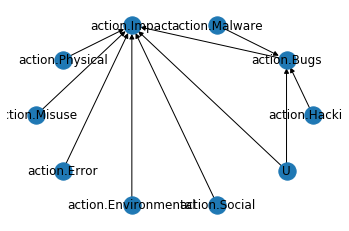

In [22]:
model.view_model()

In [23]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['action.Malware', 'action.Hacking']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                  
────────────(Expectation(action.Impact))
daction.Bugs                            
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→action.Impact then P(action.Impact|action.Bugs,,U) = P(action.Impact|action.Bugs,)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(action.Impact, action.Malware)/Derivative(action.Bugs, 
action.Malware))
Estimand assumption 1, As-if-random: If U→→action.Impact then ¬(U →→action.Malware,action.Hacking)
Estimand assumption 2, Exclusion: If we remove {action.Malware,action.Hacking}→action.Bugs, then ¬(action.Malware,action.Hacking→action.Impact)



In [24]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['action.Malware', 'action.Hacking']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                  
────────────(Expectation(action.Impact))
daction.Bugs                            
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→action.Impact then P(action.Impact|action.Bugs,,U) = P(action.Impact|action.Bugs,)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(action.Impact, action.Malware)/Derivative(action.Bugs, 
action.Malware))
Estimand assumption 1, As-if-random: If U→→action.Impact then ¬(U →→action.Malware,action.Hacking)
Estimand assumption 2, Exclusion: If we remove {action.Malware,action.Hacking}→action.Bugs, then ¬(action.Malware,action.Hacking→action.Impact)



In [25]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

ERROR:dowhy.causal_estimator:No common causes/confounders present. Propensity score based methods are not applicable


Exception: No common causes/confounders present. Propensity score based methods are not applicable